<a href="https://colab.research.google.com/github/ekourkchi/Weather_research/blob/master/Weather_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

        ET0
0  1.267761
1  1.276866
2  0.480895
3  1.288056
4  1.267654
5  0.522783
6  1.226870
7  1.359143
8  0.823787
9  0.896871


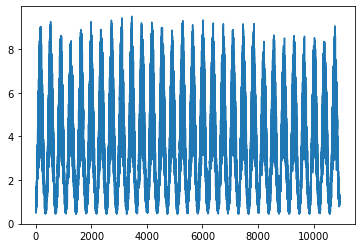

In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd

data = pd.read_excel('/content/drive/My Drive/50136-Mohe.xlsx')

for col in data.columns:
  newcol = col.split("(")[0]
  data.rename(columns={col:newcol}, inplace=True)

data.set_index("TIMESTAMP", inplace=True)

data = data.resample('1d').mean()
data["MA"] = data["ET0"].rolling('7d').mean()

data = data.interpolate(method='linear', limit_direction='forward', axis=0)

data["ET1"] = data.shift(+1, freq='d')["ET0"]
data["delta"] = data["ET0"] - data["ET1"]

data["ET0"] = data["ET0"].ffill()
data = data.dropna()




# dataframe = pandas.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', usecols=[1], engine='python')


dataframe = data.reset_index()[["ET0"]]
print(dataframe.head(10))

plt.plot(dataframe)
plt.show()

In [44]:
dataframe.head()
dataset = dataframe.values
dataset = dataset.astype('float32')

In [45]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# dataset = scaler.fit_transform(dataset)

In [46]:
# split into train and test sets
train_size = int(len(dataset) * 0.90)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

9860 1096


In [194]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		b = dataset[i+1:(i+look_back+1), 0]
		dataX.append(a)
		dataY.append(b)
	return numpy.array(dataX), numpy.array(dataY)

In [195]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [196]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

trainY = numpy.reshape(trainY, (trainY.shape[0], trainY.shape[1]))
testY = numpy.reshape(testY, (testY.shape[0], testY.shape[1]))

In [197]:
trainX[:2,:,:]

array([[[1.2677612 , 1.276866  , 0.48089507, 1.2880563 , 1.2676541 ,
         0.52278346, 1.2268697 , 1.3591427 ]],

       [[1.276866  , 0.48089507, 1.2880563 , 1.2676541 , 0.52278346,
         1.2268697 , 1.3591427 , 0.8237866 ]]], dtype=float32)

In [198]:
trainY[:2,:]

array([[1.276866  , 0.48089507, 1.2880563 , 1.2676541 , 0.52278346,
        1.2268697 , 1.3591427 , 0.8237866 ],
       [0.48089507, 1.2880563 , 1.2676541 , 0.52278346, 1.2268697 ,
        1.3591427 , 0.8237866 , 0.89687145]], dtype=float32)

In [199]:
trainY.shape

(9851, 8)

In [277]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import tensorflow as tf
import keras.backend as K

def custom_loss(y_true, y_pred):

    # calculate loss, using y_pred
    # alfa = y_true[:,:7]/y_pred[:,:7]
    # alfa = K.mean(alfa, axis=1)
    # loss = K.mean((y_true[:,7] - alfa * y_pred[:,7])**2)

    loss = K.mean((y_true - y_pred)**2, axis=1)
       
    return  K.sqrt(K.mean(loss))



# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, 8))
encoder1 = LSTM(8, return_state=True, activation='linear', go_backwards=False)
# encoder2 = LSTM(8, return_state=True)

encoder_outputs1, state_h1, state_c1 = encoder1(encoder_inputs)
# encoder_outputs2, state_h2, state_c2 = encoder2(encoder_outputs1)

model = Model(encoder_inputs, encoder_outputs1, name='test')
# tf.keras.losses.CosineSimilarity()
model.compile(loss=custom_loss, optimizer='adam', metrics=[custom_loss])
model.fit(trainX, trainY, epochs=150, batch_size=100,  
                                  validation_data=(testX, testY), verbose=2)


Epoch 1/150
99/99 - 0s - loss: 3.4171 - custom_loss: 3.4141 - val_loss: 2.5635 - val_custom_loss: 2.5489
Epoch 2/150
99/99 - 0s - loss: 2.5046 - custom_loss: 2.5022 - val_loss: 2.0348 - val_custom_loss: 2.0234
Epoch 3/150
99/99 - 0s - loss: 1.8771 - custom_loss: 1.8764 - val_loss: 1.6046 - val_custom_loss: 1.5957
Epoch 4/150
99/99 - 0s - loss: 1.7530 - custom_loss: 1.7529 - val_loss: 1.5478 - val_custom_loss: 1.5390
Epoch 5/150
99/99 - 0s - loss: 1.1800 - custom_loss: 1.1788 - val_loss: 0.7699 - val_custom_loss: 0.7655
Epoch 6/150
99/99 - 0s - loss: 0.7861 - custom_loss: 0.7849 - val_loss: 0.6182 - val_custom_loss: 0.6150
Epoch 7/150
99/99 - 0s - loss: 0.6392 - custom_loss: 0.6386 - val_loss: 0.5244 - val_custom_loss: 0.5215
Epoch 8/150
99/99 - 0s - loss: 0.5596 - custom_loss: 0.5595 - val_loss: 0.4692 - val_custom_loss: 0.4665
Epoch 9/150
99/99 - 0s - loss: 0.5123 - custom_loss: 0.5121 - val_loss: 0.4370 - val_custom_loss: 0.4345
Epoch 10/150
99/99 - 0s - loss: 0.4849 - custom_loss: 0

In [278]:
# # create and fit the LSTM network
# model = Sequential()
# # model.add(SimpleRNN(8, return_sequences=True))
# # model.add(GRU(8, return_sequences=True))
# model.add(LSTM(8, return_sequences=True))

# # model.add(Dropout(0.1))
# # model.add(Dense(16, activation = 'relu'))
# # model.add(Dropout(0.1))
# # model.add(Dense(16, activation = 'relu'))
# # model.add(Dropout(0.1))
# # model.add(Dense(1, activation='linear'))

# model.add(Dense(units=1))
# model.compile(loss='mse', optimizer='adam', metrics=["mse", 'mae'])
# model.fit(trainX, trainY, epochs=2, batch_size=100,  
#                                   validation_data=(testX, testY), verbose=2)

In [279]:
model.summary()


Model: "test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        [(None, None, 8)]         0         
_________________________________________________________________
lstm_78 (LSTM)               [(None, 8), (None, 8), (N 544       
Total params: 544
Trainable params: 544
Non-trainable params: 0
_________________________________________________________________


In [280]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

print(trainPredict.shape)
print(testPredict.shape)
print(testY.shape)

(9851, 8)
(1087, 8)
(1087, 8)


In [281]:
print(testY[1,:])
print(testX[1,:,:])
# print(testPredict[1,:]/testY[1,:])

[1.0123527  0.66552776 1.0655718  1.0112255  1.1106526  0.49434406
 0.5017166  0.5712688 ]
[[1.0054134  1.0123527  0.66552776 1.0655718  1.0112255  1.1106526
  0.49434406 0.5017166 ]]


In [282]:
YS = testY[:,7]
# alfa = testX[:,0,1:] / testPredict[:,:7]
# print(alfa[:3,:])

import numpy as np
# alfa = np.median(alfa, axis=1)

# print(alfa[:3])
print(YS[:3])

YSp = testPredict[:,7] #* alfa

print(YSp[:3])

[0.5017166 0.5712688 1.1500304]
[0.8508892  0.78280604 0.76287115]


In [283]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

RMSE = mean_squared_error(YS, YSp, squared=False)
R2 = r2_score(YS, YSp)

print("Test: ", RMSE, R2)




Test:  1.0974592 0.736272513121841
